# WEMSWOT - currents: preprocessing

In [1]:
import os
from glob import glob

import xarray as xr
import pandas as pd
import numpy as np
#from numba import njit, int32, float64

import matplotlib.pyplot as plt
#import seaborn as sns
import hvplot.pandas
import hvplot.xarray

import seaborn as sns

import pynsitu as pyn
crs = pyn.maps.crs

import utils as ut

In [2]:
store = True
#store = False

## station 2

In [3]:
aqp_dir = os.path.join(ut.current_dir, "CABLE2_AQP10602_70m")
ds = ut.read_aqd(aqp_dir, "CABLE303", profile=True, first_cell=2.5, cell_size=.20)

# ignores data after recovery
ds = ds.sel(time=slice(None, "2024/06/17 11:00:00"))

# temporal offset
ds["computer_time"] = pd.Timestamp("2024/07/26 11:23:28")
ds["instrument_time"] = pd.Timestamp("2024/07/26 11:24:08")
ds["instrument_delta_time"] = ds["computer_time"] - ds["instrument_time"]

### basic statistical properties

In [4]:
title = "station 2 [70m]"

ds_mean = ds.mean("time")
V = ["a1", "a2", "a3", "v1", "v2", "v3", "pressure", "temperature"]
ds_std = ds[V].std("time")

Text(0.5, 1.0, 'station 2 [70m]')

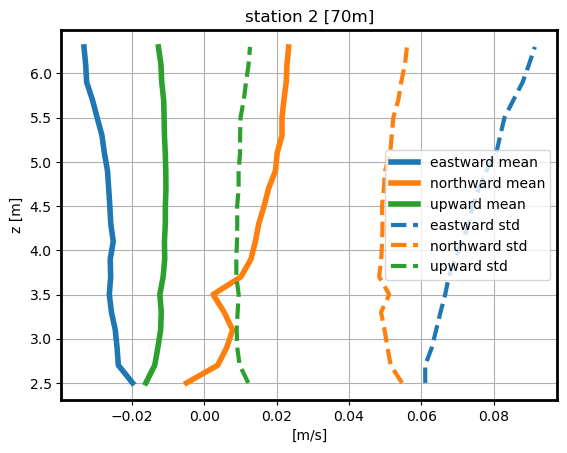

In [5]:
fig, axes = plt.subplots(1,1, sharey=True)
ax = axes
ds_mean["v1"].plot(y="z", lw=4, ax=ax, label="eastward mean")
ds_mean["v2"].plot(y="z", lw=4, ax=ax, label="northward mean")
ds_mean["v3"].plot(y="z", lw=4, ax=ax, label="upward mean")
ds_std["v1"].plot(y="z", lw=3, ls="--", ax=ax, color="C0", label="eastward std")
ds_std["v2"].plot(y="z", lw=3, ls="--", ax=ax, color="C1", label="northward std")
ds_std["v3"].plot(y="z", lw=3, ls="--", ax=ax, color="C2", label="upward std")
ax.grid()
ax.legend()
ax.set_xlabel("[m/s]")
ax.set_title(title)

In [6]:
print(f"mean/std temperature : {float(ds_mean.temperature)}  / {float(ds_std.temperature)} [degC]")
print(f"mean/std pressure : {float(ds_mean.pressure)}  / {float(ds_std.pressure)} [dbar]")

mean/std temperature : 14.750020527859236  / 0.7011001197245135 [degC]
mean/std pressure : 67.4236467253177  / 0.08345894107339655 [dbar]


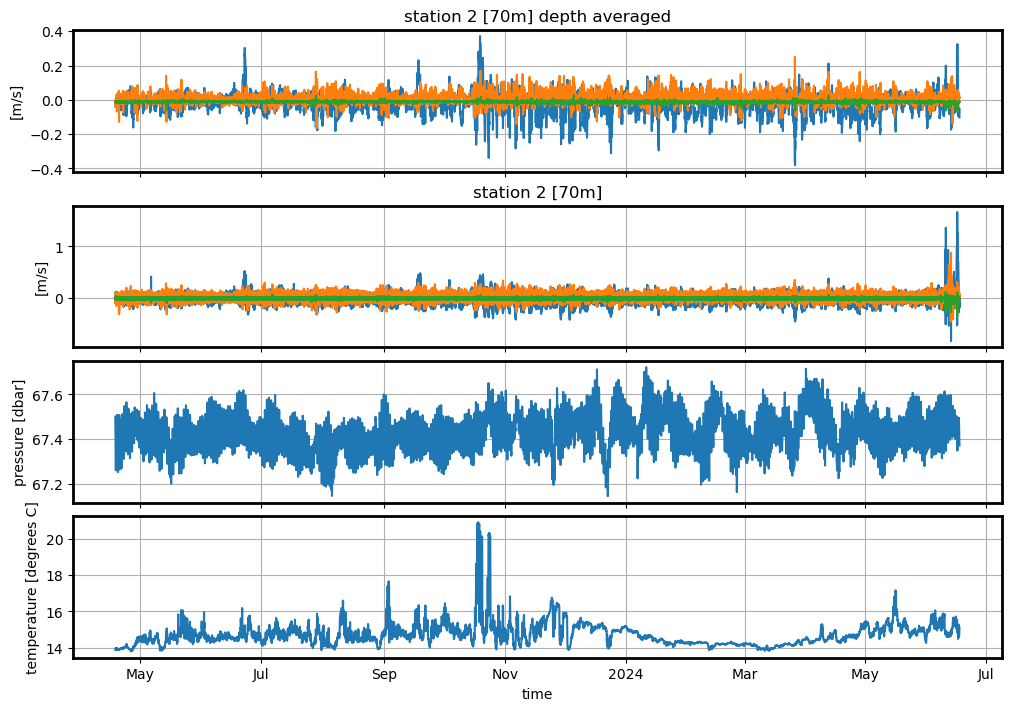

In [7]:
# checks for anomalous values

fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True, layout='constrained')
ax = axes[0]
ds["v1"].mean("bin").plot(ax=ax)
ds["v2"].mean("bin").plot(ax=ax)
ds["v3"].mean("bin").plot(ax=ax)
ax.set_xlabel("")
ax.set_ylabel("[m/s]")
ax.grid()
ax.set_title(title+ " depth averaged")

ax = axes[1]
ds["v1"].plot(ax=ax, hue="bin", color="C0", add_legend=False)
ds["v2"].plot(ax=ax, hue="bin", color="C1", add_legend=False)
ds["v3"].plot(ax=ax, hue="bin", color="C2", add_legend=False)
ax.set_xlabel("")
ax.set_ylabel("[m/s]")
ax.grid()
ax.set_title(title)

ax = axes[2]
ds["pressure"].plot(ax=ax)
ax.set_xlabel("")
ax.grid()

ax = axes[3]
ds["temperature"].plot(ax=ax)
ax.grid()

#### compute current ellipse orientation

In [8]:
major, minor = ut.compute_vector_principal_axes(ds["v1"], ds["v2"])
ds["paxes_major"] = major
ds["paxes_minor"] = minor
ds["paxes_angle"] = (major.dims, np.angle(major))
ds["paxes_angle_deg"] = np.rad2deg(ds["paxes_angle"])

Text(0.5, 1.0, 'station 2 [70m]')

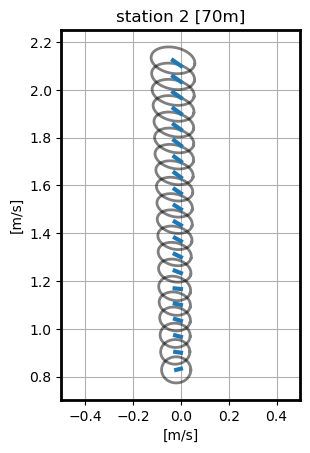

In [9]:
# mean
x_mean, y_mean = ds_mean["v1"], ds_mean["v2"]

_offset = ds["z"]/3
scale = 1/3

# ellipse
x, y = ut.build_principal_ellipse(ds["paxes_major"], ds["paxes_minor"])
fig, ax = plt.subplots(1,1)
ax.plot((x_mean+x).T, (y_mean+y).T+_offset, color="k", lw=2, alpha=.5)
dum = xr.DataArray([0,1])
ax.plot((x_mean*dum).T, (y_mean*dum).T+_offset, color="C0", lw=3)
ax.set_aspect("equal")
ax.grid()
ax.set_xlim(-.5,.5)
ax.set_xlabel("[m/s]")
ax.set_ylabel("[m/s]")
ax.set_title(title)

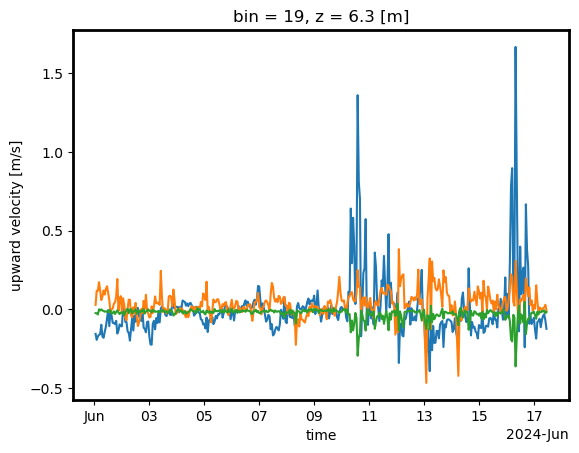

In [10]:
_ds = ds.sel(time=slice("2024/06", None))
_ds.isel(bin=-1)["v1"].plot()
_ds.isel(bin=-1)["v2"].plot()
_ds.isel(bin=-1)["v3"].plot()

Text(0.5, 1.0, 'station 2 [70m] z=6m')

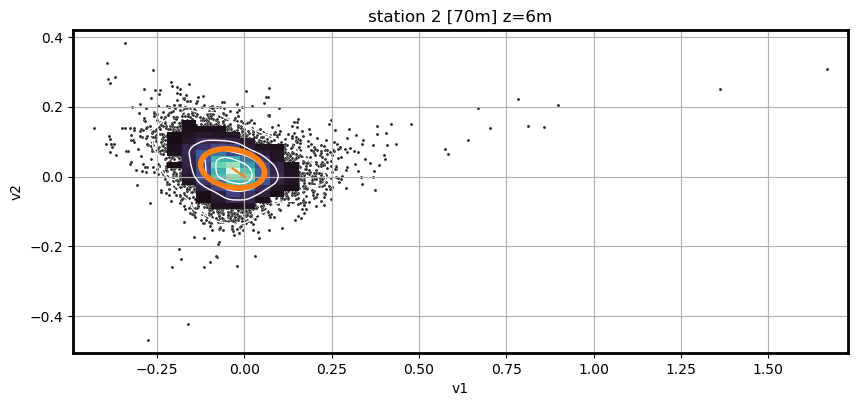

In [11]:
_ds = ds.isel(bin=-1)
#_ds = ds.isel(bin=0)

f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=_ds, x="v1", y="v2", s=5, color=".15")
sns.histplot(data=_ds, x="v1", y="v2", bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(data=_ds, x="v1", y="v2", levels=5, color="w", linewidths=1)

# mean
x_mean, y_mean = float(_ds["v1"].mean()), float(_ds["v2"].mean())
ax.plot([0,x_mean], [0,y_mean], color="C1")

# ellipse
x, y = ut.build_principal_ellipse(_ds["paxes_major"], _ds["paxes_minor"])
ax.plot(x_mean+x, y_mean+y, color="C1", lw=4)

ax.set_aspect("equal")
ax.grid()
ax.set_title(title+ f" z={int(_ds.z)}m")

Text(0.5, 1.0, 'station 2 [70m]')

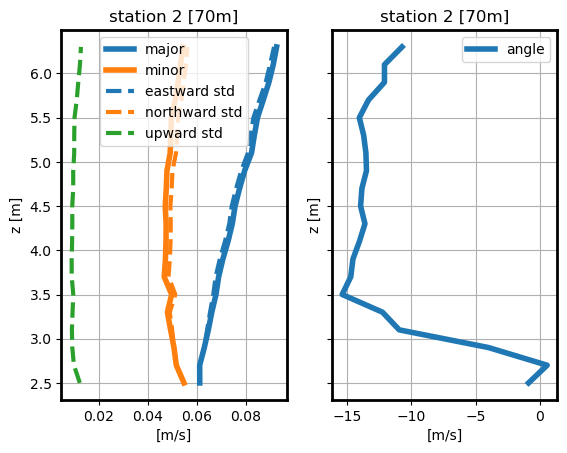

In [12]:
fig, axes = plt.subplots(1,2, sharey=True)
ax = axes[0]
np.abs(ds["paxes_major"]).plot(y="z", lw=4, ax=ax, label="major")
np.abs(ds["paxes_minor"]).plot(y="z", lw=4, ax=ax, label="minor")
ds_std["v1"].plot(y="z", lw=3, ls="--", ax=ax, color="C0", label="eastward std")
ds_std["v2"].plot(y="z", lw=3, ls="--", ax=ax, color="C1", label="northward std")
ds_std["v3"].plot(y="z", lw=3, ls="--", ax=ax, color="C2", label="upward std")
ax.grid()
ax.legend()
ax.set_xlabel("[m/s]")
ax.set_title(title)

ax = axes[1]
ds["paxes_angle_deg"].plot(y="z", lw=4, ax=ax, label="angle")
ax.grid()
ax.legend()
ax.set_xlabel("[m/s]")
ax.set_title(title)

In [13]:
# store
if store:
    nc = os.path.join(ut.current_dir, "current_station2.nc")
    ds.to_netcdf(nc, mode="w", auto_complex=True)

## station 3

In [14]:
aqp_dir = os.path.join(ut.current_dir, "CABLE3_AQP10601_120m")
ds = ut.read_aqd(aqp_dir, "CABLE204", profile=True, first_cell=2.5, cell_size=.20)

# ignores data after recovery
ds = ds.sel(time=slice(None, "2024/06/17 14:59:00"))

# temporal offset
ds["computer_time"] = pd.Timestamp("2024/07/22 14:38:33")
ds["instrument_time"] = pd.Timestamp("2024/07/22 14:39:19")
ds["instrument_delta_time"] = ds["computer_time"] - ds["instrument_time"]

### basic statistical properties

In [15]:
title = "station 3 [120m]"

ds_mean = ds.mean("time")
V = ["a1", "a2", "a3", "v1", "v2", "v3", "pressure", "temperature"]
ds_std = ds[V].std("time")

Text(0.5, 1.0, 'station 3 [120m]')

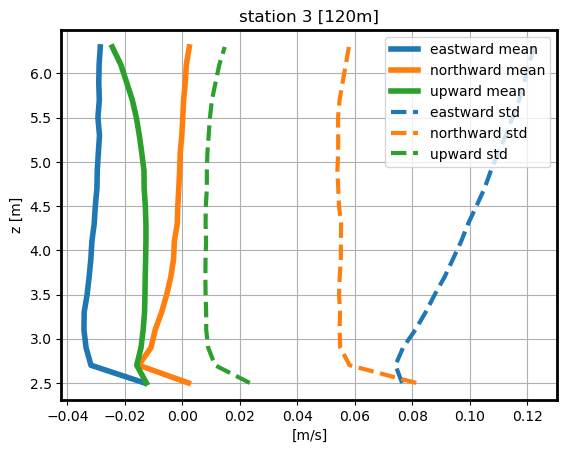

In [16]:
fig, axes = plt.subplots(1,1, sharey=True)
ax = axes
ds_mean["v1"].plot(y="z", lw=4, ax=ax, label="eastward mean")
ds_mean["v2"].plot(y="z", lw=4, ax=ax, label="northward mean")
ds_mean["v3"].plot(y="z", lw=4, ax=ax, label="upward mean")
ds_std["v1"].plot(y="z", lw=3, ls="--", ax=ax, color="C0", label="eastward std")
ds_std["v2"].plot(y="z", lw=3, ls="--", ax=ax, color="C1", label="northward std")
ds_std["v3"].plot(y="z", lw=3, ls="--", ax=ax, color="C2", label="upward std")
ax.grid()
ax.legend()
ax.set_xlabel("[m/s]")
ax.set_title(title)

In [17]:
print(f"mean/std temperature : {float(ds_mean.temperature)}  / {float(ds_std.temperature)} [degC]")
print(f"mean/std pressure : {float(ds_mean.pressure)}  / {float(ds_std.pressure)} [dbar]")

mean/std temperature : 14.194292554230993  / 0.3101105743292072 [degC]
mean/std pressure : 118.6637369552472  / 0.08520033059873548 [dbar]


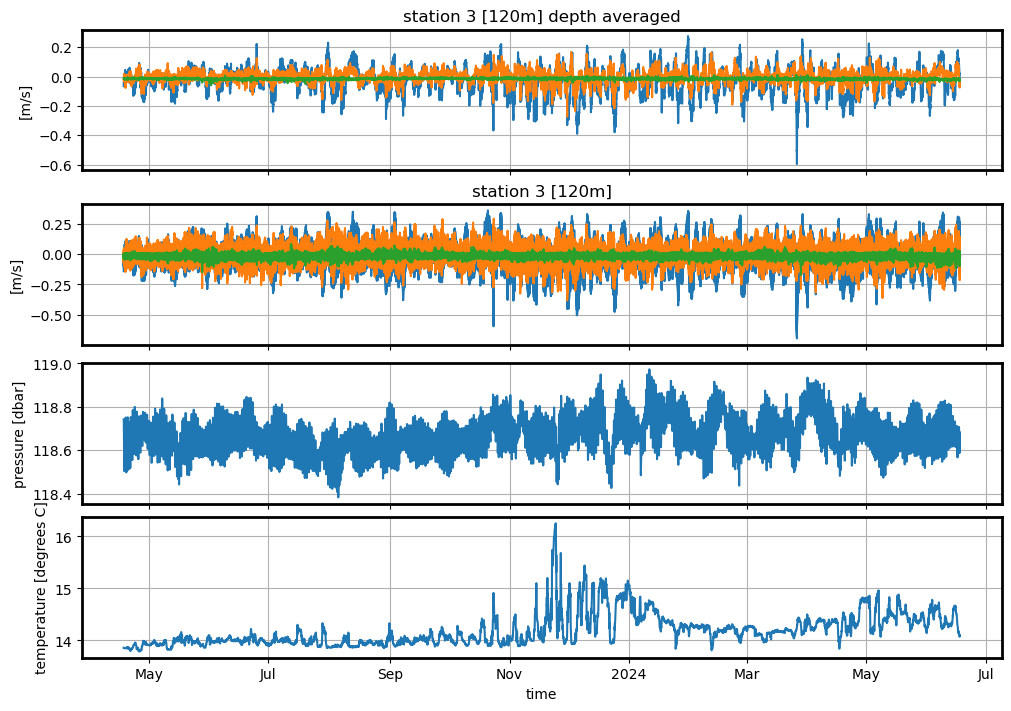

In [18]:
# checks for anomalous values

fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True, layout='constrained')
ax = axes[0]
ds["v1"].mean("bin").plot(ax=ax)
ds["v2"].mean("bin").plot(ax=ax)
ds["v3"].mean("bin").plot(ax=ax)
ax.set_xlabel("")
ax.set_ylabel("[m/s]")
ax.grid()
ax.set_title(title+ " depth averaged")

ax = axes[1]
ds["v1"].plot(ax=ax, hue="bin", color="C0", add_legend=False)
ds["v2"].plot(ax=ax, hue="bin", color="C1", add_legend=False)
ds["v3"].plot(ax=ax, hue="bin", color="C2", add_legend=False)
ax.set_xlabel("")
ax.set_ylabel("[m/s]")
ax.grid()
ax.set_title(title)

ax = axes[2]
ds["pressure"].plot(ax=ax)
ax.set_xlabel("")
ax.grid()

ax = axes[3]
ds["temperature"].plot(ax=ax)
ax.grid()

#### compute current ellipse orientation

In [19]:
major, minor = ut.compute_vector_principal_axes(ds["v1"], ds["v2"])
ds["paxes_major"] = major
ds["paxes_minor"] = minor
ds["paxes_angle"] = (major.dims, np.angle(major))
ds["paxes_angle_deg"] = np.rad2deg(ds["paxes_angle"])

Text(0.5, 1.0, 'station 3 [120m]')

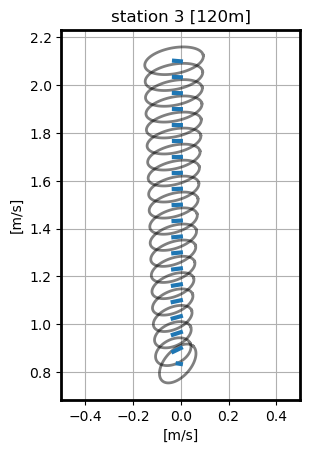

In [20]:
# mean
x_mean, y_mean = ds_mean["v1"], ds_mean["v2"]

_offset = ds["z"]/3
scale = 1/3

# ellipse
x, y = ut.build_principal_ellipse(ds["paxes_major"], ds["paxes_minor"])
fig, ax = plt.subplots(1,1)
ax.plot((x_mean+x).T, (y_mean+y).T+_offset, color="k", lw=2, alpha=.5)
dum = xr.DataArray([0,1])
ax.plot((x_mean*dum).T, (y_mean*dum).T+_offset, color="C0", lw=3)
ax.set_aspect("equal")
ax.grid()
ax.set_xlim(-.5,.5)
ax.set_xlabel("[m/s]")
ax.set_ylabel("[m/s]")
ax.set_title(title)

Text(0.5, 1.0, 'station 3 [120m] z=6m')

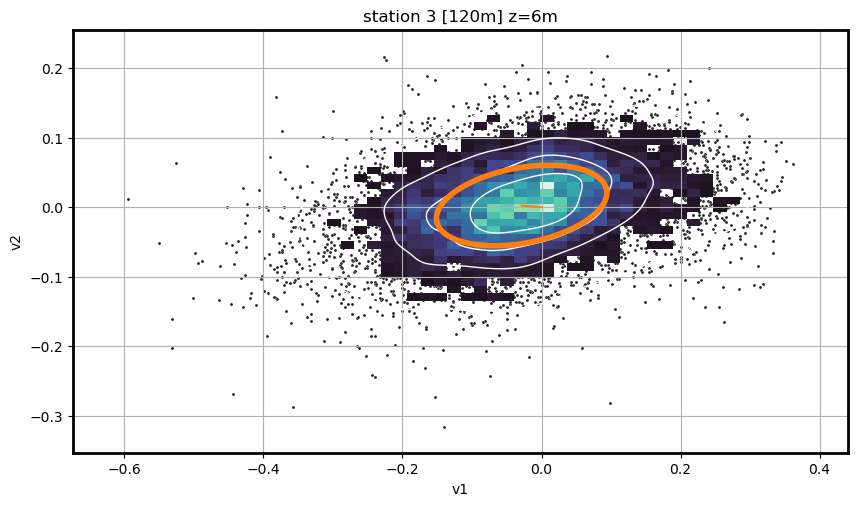

In [21]:
_ds = ds.isel(bin=-1)
#_ds = ds.isel(bin=0)

f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=_ds, x="v1", y="v2", s=5, color=".15")
sns.histplot(data=_ds, x="v1", y="v2", bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(data=_ds, x="v1", y="v2", levels=5, color="w", linewidths=1)

# mean
x_mean, y_mean = float(_ds["v1"].mean()), float(_ds["v2"].mean())
ax.plot([0,x_mean], [0,y_mean], color="C1")

# ellipse
x, y = ut.build_principal_ellipse(_ds["paxes_major"], _ds["paxes_minor"])
ax.plot(x_mean+x, y_mean+y, color="C1", lw=4)

ax.set_aspect("equal")
ax.grid()
ax.set_title(title+ f" z={int(_ds.z)}m")

Text(0.5, 1.0, 'station 3 [120m]')

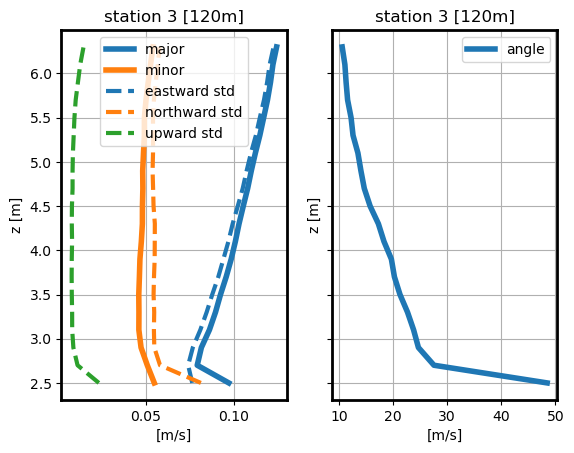

In [22]:
fig, axes = plt.subplots(1,2, sharey=True)
ax = axes[0]
np.abs(ds["paxes_major"]).plot(y="z", lw=4, ax=ax, label="major")
np.abs(ds["paxes_minor"]).plot(y="z", lw=4, ax=ax, label="minor")
ds_std["v1"].plot(y="z", lw=3, ls="--", ax=ax, color="C0", label="eastward std")
ds_std["v2"].plot(y="z", lw=3, ls="--", ax=ax, color="C1", label="northward std")
ds_std["v3"].plot(y="z", lw=3, ls="--", ax=ax, color="C2", label="upward std")
ax.grid()
ax.legend()
ax.set_xlabel("[m/s]")
ax.set_title(title)

ax = axes[1]
ds["paxes_angle_deg"].plot(y="z", lw=4, ax=ax, label="angle")
ax.grid()
ax.legend()
ax.set_xlabel("[m/s]")
ax.set_title(title)

In [23]:
# store
if store:
    nc = os.path.join(ut.current_dir, "current_station3.nc")
    ds.to_netcdf(nc, mode="w", auto_complex=True)

---
## station 4

In [27]:
aqp_dir = os.path.join(ut.current_dir, "CABLE4_AQDDW8216")
ds = ut.read_aqd(aqp_dir, "cable402", profile=False)

# ignores data after recovery
ds = ds.sel(time=slice(None, "2024/06/11 19:41:16"))

# temporal offset
ds["computer_time"] = pd.Timestamp("2024/07/23 07:08:22")
ds["instrument_time"] = pd.Timestamp("2024/07/23 07:09:06")
ds["instrument_delta_time"] = ds["computer_time"] - ds["instrument_time"]

### basic statistical properties

In [28]:
title = "station 4 [900m]"

ds_mean = ds.mean("time")
V = ["a1", "a2", "a3", "v1", "v2", "v3", "pressure", "temperature"]
ds_std = ds[V].std("time")

In [29]:
for i in range(1,4):
    v = f"v{i}"
    print(f" mean/std v{i} : {float(ds_mean[v])} / {float(ds_std[v])} ")

 mean/std v1 : -0.002060787104461803 / 0.03170998317120672 
 mean/std v2 : 0.00037826029392294463 / 0.032755081248396746 
 mean/std v3 : -0.005471600688468159 / 0.016619345825860735 


In [30]:
print(f"mean/std temperature : {float(ds_mean.temperature)}  / {float(ds_std.temperature)} [degC]")
print(f"mean/std pressure : {float(ds_mean.pressure)}  / {float(ds_std.pressure)} [dbar]")

mean/std temperature : 13.464354892095855  / 0.07042308610650208 [degC]
mean/std pressure : 915.4703983681982  / 0.2001299213040126 [dbar]


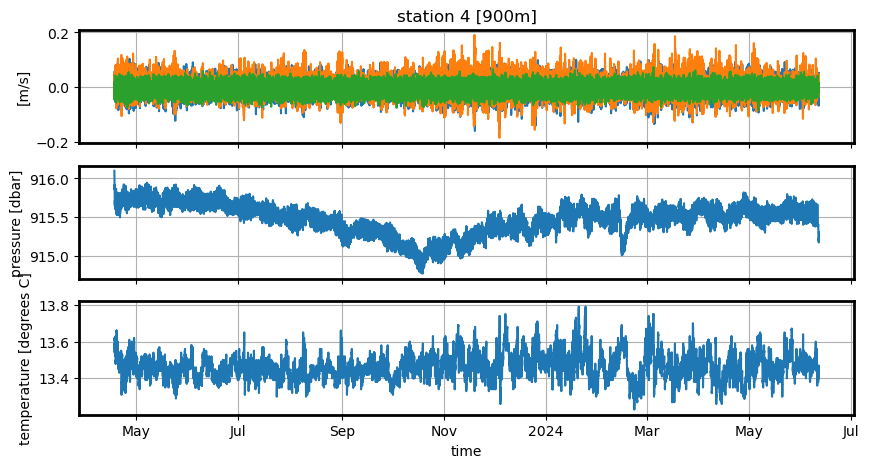

In [31]:
# checks for anomalous values

fig, axes = plt.subplots(3,1, figsize=(10,5), sharex=True)
ax = axes[0]
ds["v1"].plot(ax=ax)
ds["v2"].plot(ax=ax)
ds["v3"].plot(ax=ax)
ax.set_xlabel("")
ax.set_ylabel("[m/s]")
ax.grid()
ax.set_title(title)

ax = axes[1]
ds["pressure"].plot(ax=ax)
ax.set_xlabel("")
ax.grid()

ax = axes[2]
ds["temperature"].plot(ax=ax)
ax.grid()

#### compute current ellipse orientation

In [32]:
major, minor = ut.compute_vector_principal_axes(ds["v1"], ds["v2"])
ds["paxes_major"] = major
ds["paxes_minor"] = minor
ds["paxes_angle"] = (major.dims, np.angle(major))
ds["paxes_angle_deg"] = np.rad2deg(ds["paxes_angle"])

In [37]:
x_mean, y_mean

(-0.002060787104461803, 0.00037826029392294463)

Text(0.5, 1.0, 'station 4 [900m]')

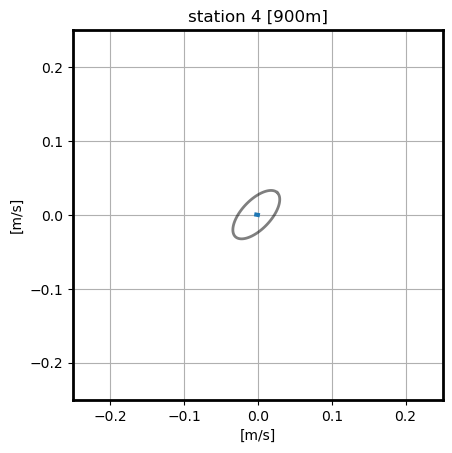

In [33]:
# mean
x_mean, y_mean = ds_mean["v1"], ds_mean["v2"]

scale = 1/3

# ellipse
x, y = ut.build_principal_ellipse(ds["paxes_major"], ds["paxes_minor"])
fig, ax = plt.subplots(1,1)
ax.plot((x_mean+x).T, (y_mean+y).T, color="k", lw=2, alpha=.5)
dum = xr.DataArray([0,1])
ax.plot((x_mean*dum).T, (y_mean*dum).T, color="C0", lw=3)
ax.set_aspect("equal")
ax.grid()
ax.set_xlim(-.25,.25)
ax.set_ylim(-.25,.25)
ax.set_xlabel("[m/s]")
ax.set_ylabel("[m/s]")
ax.set_title(title)

Text(0.5, 1.0, 'station 4 [900m]')

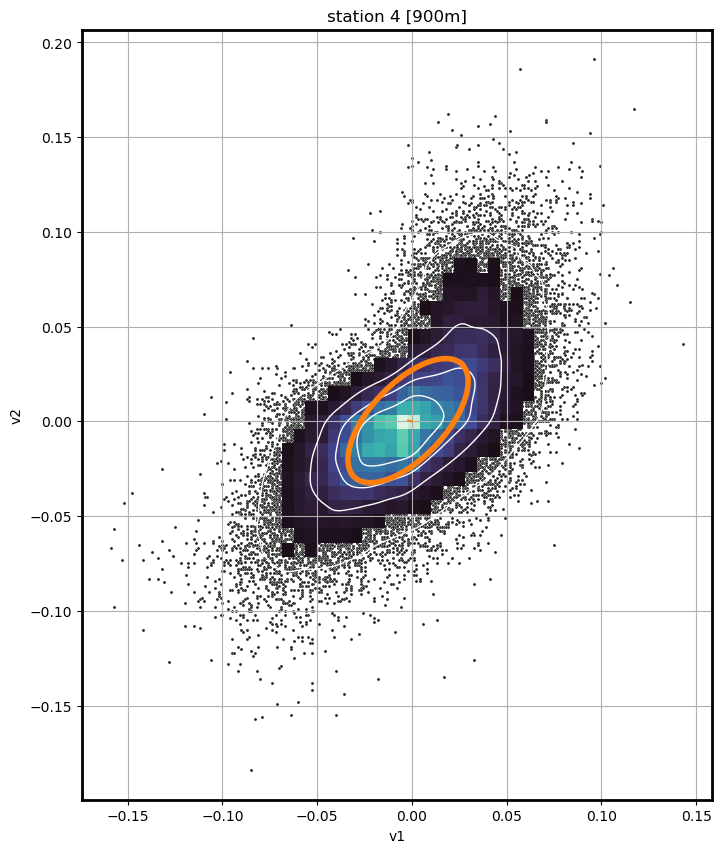

In [34]:
_ds = ds

f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=_ds, x="v1", y="v2", s=5, color=".15")
sns.histplot(data=_ds, x="v1", y="v2", bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(data=_ds, x="v1", y="v2", levels=5, color="w", linewidths=1)

# mean
x_mean, y_mean = float(_ds["v1"].mean()), float(_ds["v2"].mean())
ax.plot([0,x_mean], [0,y_mean], color="C1")

# ellipse
x, y = ut.build_principal_ellipse(_ds["paxes_major"], _ds["paxes_minor"])
ax.plot(x_mean+x, y_mean+y, color="C1", lw=4)

ax.set_aspect("equal")
ax.grid()
ax.set_title(title)

In [35]:
for v in ["paxes_major", "paxes_minor"]:
    print(f" {v} : {float(np.abs(ds[v]))} m/s")

v = "paxes_angle_deg"
print(f" {v} : {float(ds[v])} deg")

 paxes_major : 0.04114001052914372 m/s
 paxes_minor : 0.019644793558834608 m/s
 paxes_angle_deg : 46.47784842062605 deg


In [36]:

# store
if store:
    nc = os.path.join(ut.current_dir, "current_station4.nc")
    ds.to_netcdf(nc, mode="w", auto_complex=True)

## using pynsitu: rotary spectrum

In [69]:
df = ds.to_dataframe().drop(columns=["computer_time", "instrument_time", "instrument_delta_time"]).ts.resample_uniform("10min").fillna(0.)

In [119]:
(df.index - df.index[0])/pd.Timedelta("1d") 

Index([                  0.0, 0.0005526213301801921, 0.0011052426603603842,
       0.0016578639905405765, 0.0022104853207207684,  0.002763106650900961,
        0.003315727981081153, 0.0038683493112613454,  0.004420970641441537,
       0.0049735919716217296,
       ...
           33.46343202773136,     33.46398464906154,    33.464537270391716,
          33.465089891721895,     33.46564251305208,    33.466195134382254,
           33.46674775571244,     33.46730037704262,      33.4678529983728,
           33.46840561970298],
      dtype='float64', name='time', length=60564)

In [137]:
omega = 2*2*np.pi
df["v1_syn"] = 0.1*np.cos( (df.index-df.index[0])/pd.Timedelta("1d") *omega)
df["v2_syn"] = 0.1*np.cos( (df.index-df.index[0])/pd.Timedelta("1d") *omega)

In [139]:
E = df.ts.spectrum(nperseg=24 * 6 * 15, complex=("v1", "v2"), unit="1d")
Esyn = df.ts.spectrum(nperseg=24 * 6 * 15, complex=("v1_syn", "v2_syn"), unit="1d")

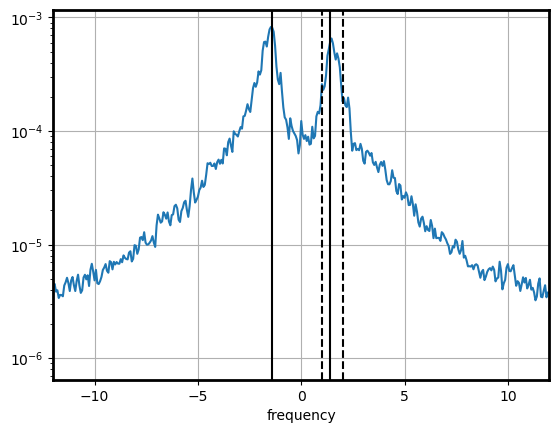

In [142]:
fig, ax = plt.subplots(1,1)
E["v1_v2"].plot()
#Esyn["v1_syn_v2_syn"].plot()
ax.set_yscale("log")
ax.set_xlim(-12,12)
ax.grid()
#ax.axvline(-2)
ax.axvline(24/17, color="k", ls="-")
ax.axvline(-24/17, color="k", ls="-")
ax.axvline(1, color="k", ls="--")
ax.axvline(2, color="k", ls="--")
#ax.set_ylim(1e-8, 1e1)